In [1]:
# To enable plotting graphs in Jupyter notebook
%matplotlib inline 

# Numerical libraries
import numpy as np
import math

# To handle data in form of rows and columns 
import pandas as pd

# To split data into train and test
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score, GridSearchCV

# Import machine learning library
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Import RFE for feature selection
from sklearn.feature_selection import RFE

# Preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Import ploting libraries
import matplotlib.pyplot as plt   

# Import seaborn for statistical plots
import seaborn as sns

# Import zscore for standard score
from scipy.stats import zscore

# To evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Import warnings to hide them
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the CSV file into pandas dataframe
df = pd.read_csv('challenge2_dataset.csv')

# Check top 5 records to get a feel of the data structure
df.head()

,1,2,3,Target
0,0.60,0.31,13.0,False
1,0.74,0.33,21.0,False
2,0.54,0.19,NaN,True
3,0.46,NaN,9.0,False
4,0.77,0.15,15.0,True


In [3]:
print('Number of rows : ',df.shape[0])
print('Number of columns : ',df.shape[1])

Number of rows :  1995
Number of columns :  4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995 entries, 0 to 1994
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       1992 non-null   float64
 1   2       1992 non-null   float64
 2   3       1993 non-null   float64
 3   Target  1984 non-null   object 
dtypes: float64(3), object(1)
memory usage: 62.5+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
1,1992.0,1.488800,22.145983,0.4,0.49,0.60,0.71,600.0
2,1992.0,1.741546,58.456685,0.1,0.15,0.22,0.30,2600.0
3,1993.0,16.333166,42.407440,0.0,12.00,15.00,19.00,1900.0


In [6]:
# Check for null values
df.isnull().sum()

1          3
2          3
3          2
Target    11
dtype: int64

* **19 Null values**
* we can impute null values by mean, median, mode

In [7]:
df['1'].fillna(df['1'].mean(), inplace = True)
df['2'].fillna(df['2'].mean(), inplace = True)
df['3'].fillna(df['3'].mean(), inplace = True)
df['Target'].fillna(method ='ffill', inplace = True)

In [8]:
# shape of the data before deleting missing entries
print('Before : ',df.shape)

# deleting duplicates, except the first observation
df.drop_duplicates(keep='first')

# shape of the data after deleting duplicate entries
print('After : ',df.shape)

Before :  (1995, 4)
After :  (1995, 4)


* **No duplicates**

### Let us do a pair plot analysis to visually check number of likely clusters

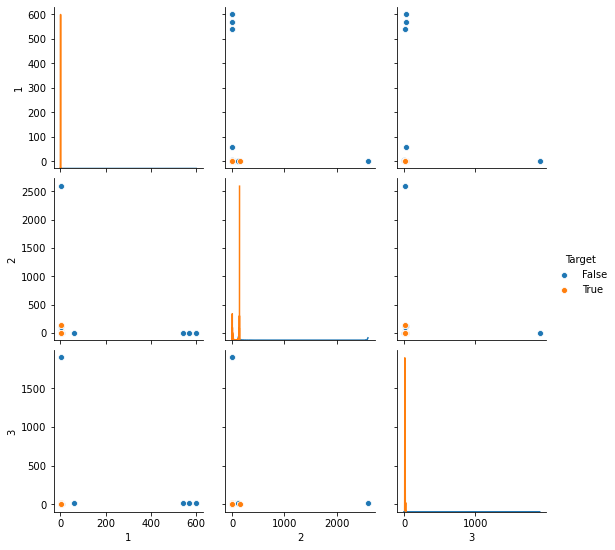

Wall time: 3.63 s


In [9]:
%%time
sns.pairplot(df, diag_kind='kde', hue = 'Target')   # to plot density curve instead of histogram
plt.show()

#sns.pairplot(df)  # to plot histogram, the default

In [10]:
df_attr = df.iloc[:,:-1]
df_tar = df['Target']

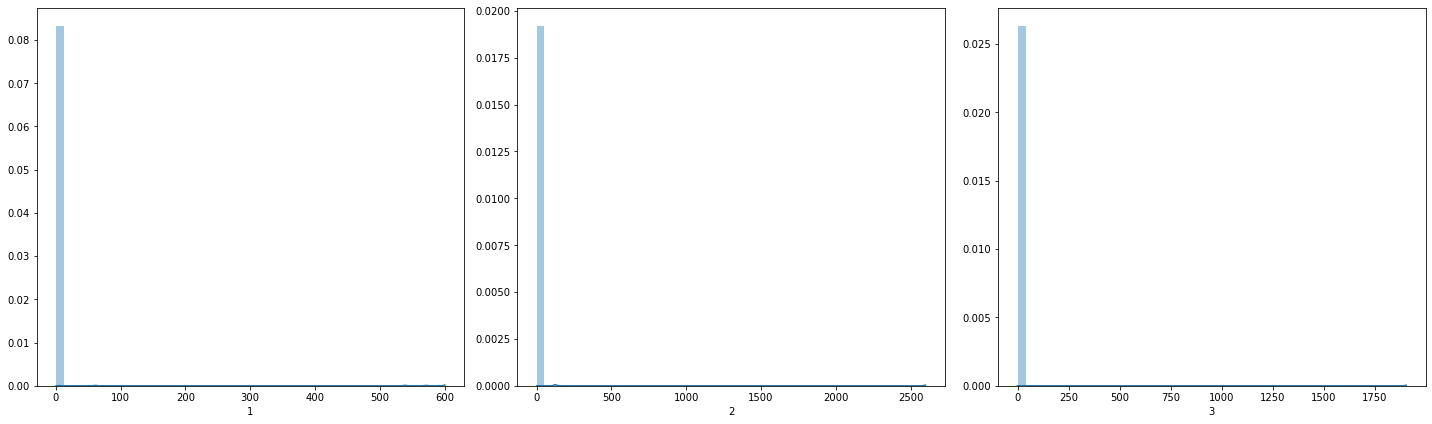

In [11]:
# pick number of columns
ncol = 3
# make sure enough subplots
nrow = math.floor((len(df_attr.columns) + ncol - 1) / ncol)
# create the axes
height = 6 * nrow
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, height))

# go over a linear list of data
for i, col in enumerate(df_attr.columns):
    # compute an appropriate index (1d or 2d)
    ix = np.unravel_index(i, ax.shape) 

    sns.distplot(df_attr[col], ax=ax[ix])

plt.tight_layout()
plt.show();

* **Right Skewed**

In [12]:
X = df_attr # select all rows and columns which are the attributes
y = df_tar  # select all rows and column which is the target

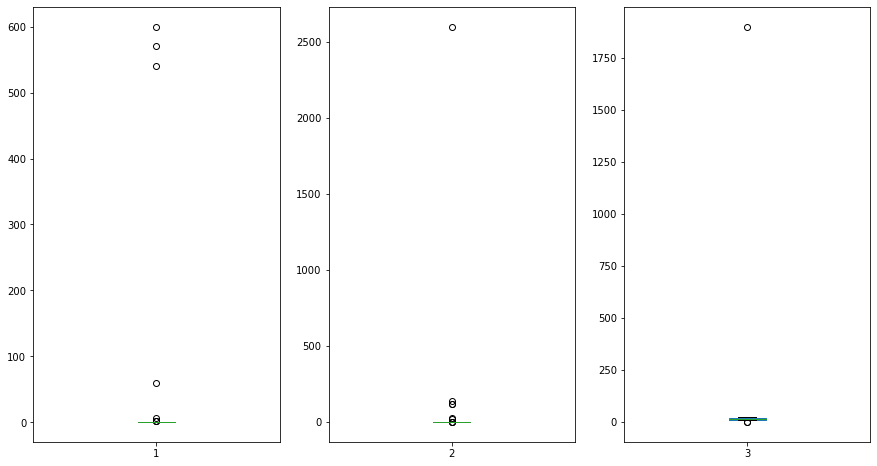

In [13]:
X.plot(kind= 'box' , subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(15,8))
plt.show();

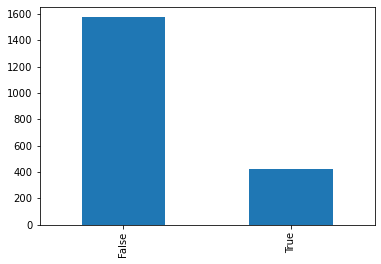

In [14]:
# target variable
y.value_counts().plot(kind='bar')
plt.show()

In [15]:
df['Target'].value_counts(normalize = True)*100

False    78.847118
True     21.152882
Name: Target, dtype: float64

* **Data is imbalanced**

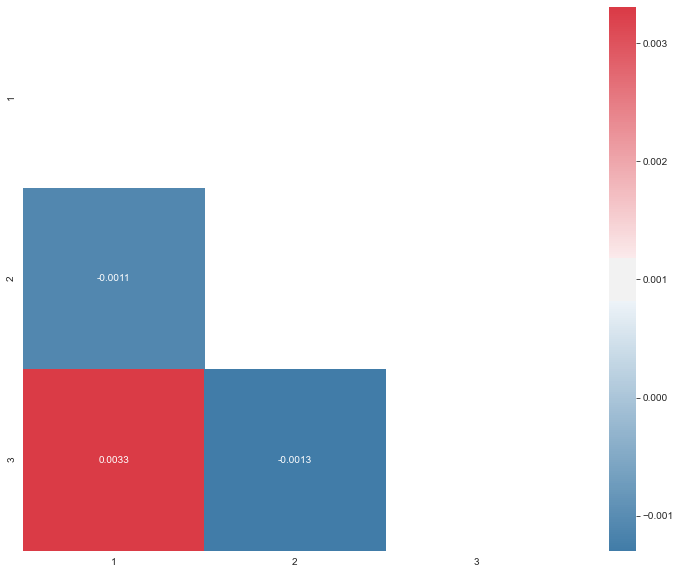

In [16]:
# Set the style of the visualization
sns.set_style('white')

# Create a Correlation matrix
corr = df_attr.corr()

# Generate a mask the size of our Correlation matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = None

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, sep=20, n=9, as_cmap=True)

# Draw the heatmapwith the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, mask=mask, square=True, annot=True)

plt.show();

In [17]:
### Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

#### Are both train and test representative of the overall data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025E824DF470>,
      dtype=object)

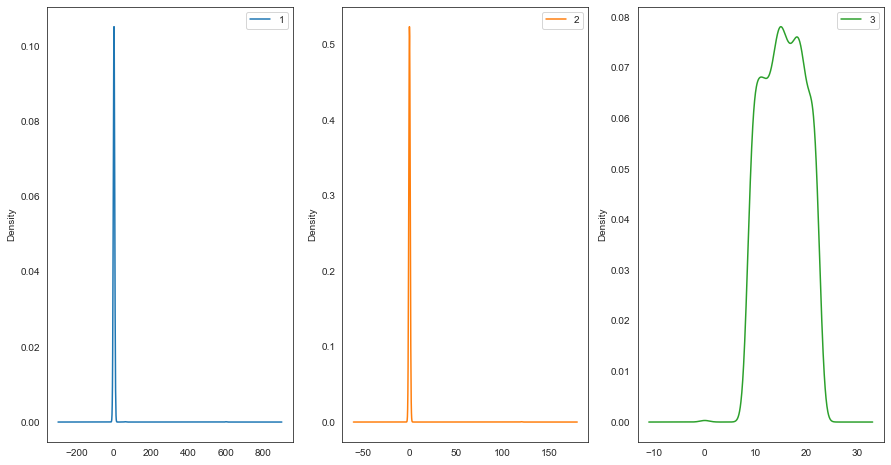

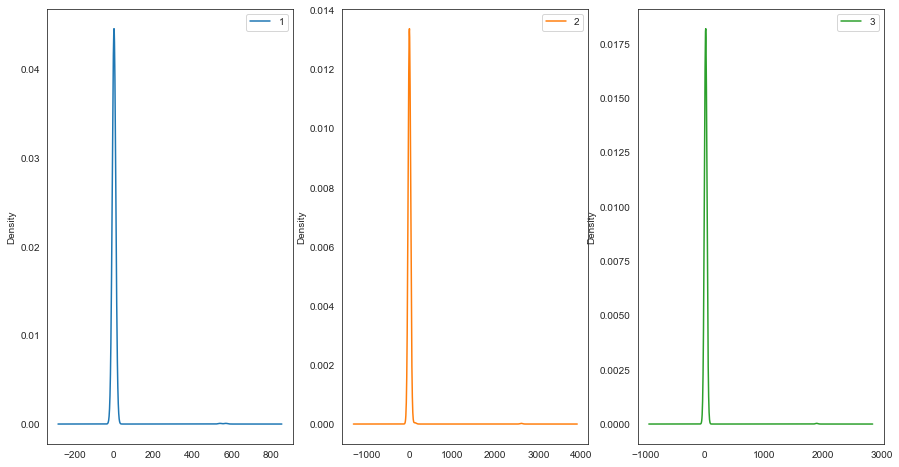

In [18]:
X_train.plot(kind= 'kde' , subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(15,8))
X_test.plot(kind= 'kde' , subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(15,8))

#### Feature Scaling

One last step before we move to splitting our data to Train-Test Split is to scale the features to some specific range. This is called Feature Scaling. But before we do this we will split the feature and target variables because we don't want to scale our target variable.

In [19]:
cols = X_train.columns
scaler = StandardScaler()

# apply feature scaling to all features
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [20]:
# our data after feature scaling
X_train = pd.DataFrame(X_scaled_train, columns = cols)
X_test = pd.DataFrame(X_scaled_test, columns = cols)

### MODEL BUILT ON TRAIN TEST SPLIT DATA

#### Logistic Regression

In [21]:
LR = LogisticRegression()
LR.fit(X_train , y_train)

y_pred_LR = LR.predict(X_test)

#score
print("Train Accuracy -- ", LR.score(X_train, y_train)*100)
print("Test Accuracy -- ", LR.score(X_test, y_test)*100)

# Cross validation score
scoresdt = cross_val_score(LR, X, y, cv=10)
print('Cross validation score         : ',round(scoresdt.mean(), 4))
print('Cross validation std           : ',round(scoresdt.std(), 4))

#Bias Variance Error Calculation
print("Bias Errors (1-Accuracy/R2)    : ",round(1-np.mean(scoresdt), 4))
print("Variance Errors                : ",round(np.var(scoresdt), 4))

print(classification_report(y_test,y_pred_LR))

Train Accuracy --  85.38681948424069
Test Accuracy --  86.14357262103506
Cross validation score         :  0.8451
Cross validation std           :  0.0199
Bias Errors (1-Accuracy/R2)    :  0.1549
Variance Errors                :  0.0004
              precision    recall  f1-score   support

       False       0.89      0.93      0.91       464
        True       0.72      0.62      0.67       135

    accuracy                           0.86       599
   macro avg       0.81      0.78      0.79       599
weighted avg       0.86      0.86      0.86       599



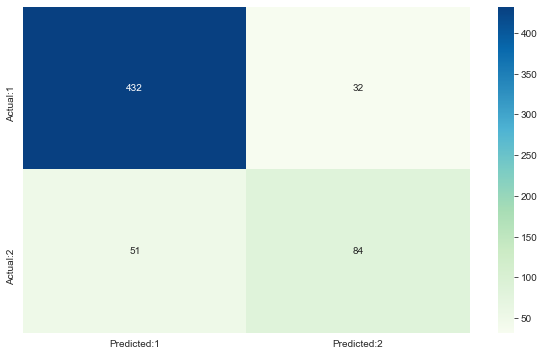

In [22]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_LR)
conf_matrix=pd.DataFrame(data=cm,
                         columns=['Predicted:1','Predicted:2'],
                         index=['Actual:1','Actual:2'])
plt.figure(figsize = (10,6))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu")

#### Random forest

In [23]:
RF = RandomForestClassifier(n_jobs = -1)
#fit
RF.fit(X_train, y_train)
#prediction
y_pred_RF = RF.predict(X_test)

#score
print("Train Accuracy -- ", RF.score(X_train, y_train)*100)
print("Test Accuracy -- ", RF.score(X_test, y_test)*100)

# Cross validation score
scoresdt = cross_val_score(RF, X, y, cv=10)
print('Cross validation score         : ',round(scoresdt.mean(), 4))
print('Cross validation std           : ',round(scoresdt.std(), 4))

#Bias Variance Error Calculation
print("Bias Errors (1-Accuracy/R2)    : ",round(1-np.mean(scoresdt), 4))
print("Variance Errors                : ",round(np.var(scoresdt), 4))

print(classification_report(y_test,y_pred_RF))

Train Accuracy --  100.0
Test Accuracy --  96.661101836394
Cross validation score         :  0.9689
Cross validation std           :  0.0113
Bias Errors (1-Accuracy/R2)    :  0.0311
Variance Errors                :  0.0001
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       464
        True       0.91      0.94      0.93       135

    accuracy                           0.97       599
   macro avg       0.95      0.96      0.95       599
weighted avg       0.97      0.97      0.97       599



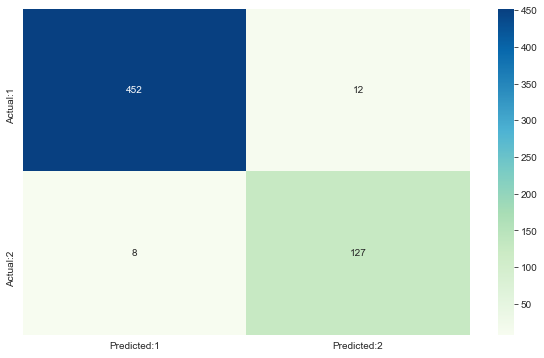

In [24]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_RF)
conf_matrix=pd.DataFrame(data=cm,
                         columns=['Predicted:1','Predicted:2'],
                         index=['Actual:1','Actual:2'])
plt.figure(figsize = (10,6))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu")

#### Gradient boosting

In [25]:
GB = GradientBoostingClassifier()
#fit
GB.fit(X_train, y_train)
#prediction
y_pred_GB = GB.predict(X_test)

#score
print("Train Accuracy -- ", GB.score(X_train, y_train)*100)
print("Test Accuracy -- ", GB.score(X_test, y_test)*100)

# Cross validation score
scoresdt = cross_val_score(GB, X, y, cv=10)
print('Cross validation score         : ',round(scoresdt.mean(), 4))
print('Cross validation std           : ',round(scoresdt.std(), 4))

#Bias Variance Error Calculation
print("Bias Errors (1-Accuracy/R2)    : ",round(1-np.mean(scoresdt), 4))
print("Variance Errors                : ",round(np.var(scoresdt), 4))

print(classification_report(y_test,y_pred_GB))

Train Accuracy --  99.06876790830945
Test Accuracy --  96.661101836394
Cross validation score         :  0.9659
Cross validation std           :  0.0139
Bias Errors (1-Accuracy/R2)    :  0.0341
Variance Errors                :  0.0002
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       464
        True       0.90      0.96      0.93       135

    accuracy                           0.97       599
   macro avg       0.94      0.96      0.95       599
weighted avg       0.97      0.97      0.97       599



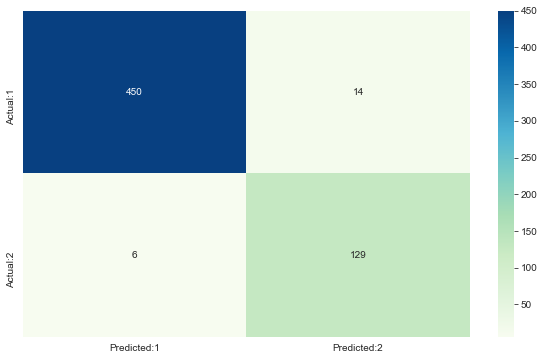

In [26]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_GB)
conf_matrix=pd.DataFrame(data=cm,
                         columns=['Predicted:1','Predicted:2'],
                         index=['Actual:1','Actual:2'])
plt.figure(figsize = (10,6))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu")

#### LGBM

In [27]:
LGBM = LGBMClassifier(n_estimators=200, n_jobs = -1)
#fit
LGBM.fit(X_train, y_train)
#prediction
y_pred_LGBM = LGBM.predict(X_test)

#score
print("Train Accuracy -- ", LGBM.score(X_train, y_train)*100)
print("Test Accuracy -- ", LGBM.score(X_test, y_test)*100)

# Cross validation score
scoresdt = cross_val_score(LGBM, X, y, cv=10)
print('Cross validation score         : ',round(scoresdt.mean(), 4))
print('Cross validation std           : ',round(scoresdt.std(), 4))

#Bias Variance Error Calculation
print("Bias Errors (1-Accuracy/R2)    : ",round(1-np.mean(scoresdt), 4))
print("Variance Errors                : ",round(np.var(scoresdt), 4))

print(classification_report(y_test,y_pred_LGBM))

Train Accuracy --  100.0
Test Accuracy --  95.82637729549248
Cross validation score         :  0.9649
Cross validation std           :  0.0116
Bias Errors (1-Accuracy/R2)    :  0.0351
Variance Errors                :  0.0001
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       464
        True       0.88      0.94      0.91       135

    accuracy                           0.96       599
   macro avg       0.93      0.95      0.94       599
weighted avg       0.96      0.96      0.96       599



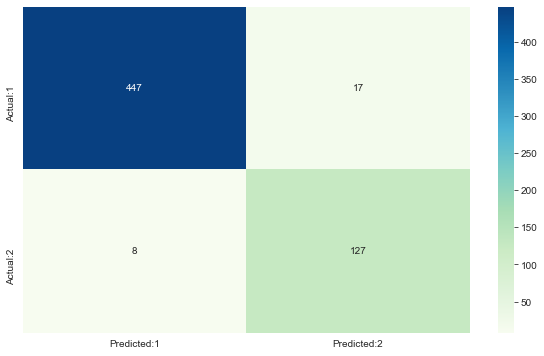

In [28]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_LGBM)
conf_matrix=pd.DataFrame(data=cm,
                         columns=['Predicted:1','Predicted:2'],
                         index=['Actual:1','Actual:2'])
plt.figure(figsize = (10,6))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu")

#### KNN

In [29]:
KNN = KNeighborsClassifier(metric='minkowski', n_jobs = -1)

#fit
KNN.fit(X_train, y_train)
#prediction
y_pred_KNN = KNN.predict(X_test)

#score
print("Train Accuracy -- ", KNN.score(X_train, y_train)*100)
print("Test Accuracy -- ", KNN.score(X_test, y_test)*100)

# Cross validation score
scoresdt = cross_val_score(KNN, X, y, cv=10)
print('Cross validation score         : ',round(scoresdt.mean(), 4))
print('Cross validation std           : ',round(scoresdt.std(), 4))

#Bias Variance Error Calculation
print("Bias Errors (1-Accuracy/R2)    : ",round(1-np.mean(scoresdt), 4))
print("Variance Errors                : ",round(np.var(scoresdt), 4))

print(classification_report(y_test,y_pred_KNN))

Train Accuracy --  97.134670487106
Test Accuracy --  95.49248747913188
Cross validation score         :  0.9699
Cross validation std           :  0.0077
Bias Errors (1-Accuracy/R2)    :  0.0301
Variance Errors                :  0.0001
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       464
        True       0.88      0.93      0.90       135

    accuracy                           0.95       599
   macro avg       0.93      0.94      0.94       599
weighted avg       0.96      0.95      0.96       599



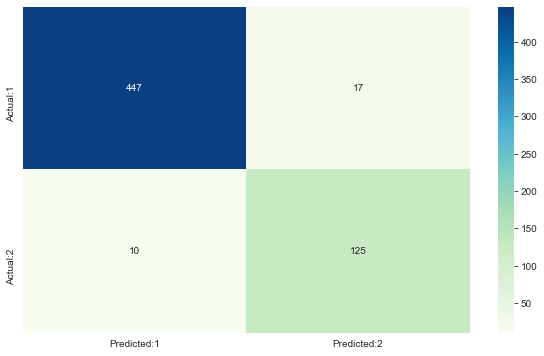

In [30]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_KNN)
conf_matrix=pd.DataFrame(data=cm,
                         columns=['Predicted:1','Predicted:2'],
                         index=['Actual:1','Actual:2'])
plt.figure(figsize = (10,6))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="GnBu")

## Reading the prediction file into pandas dataframe

In [31]:
pred = pd.read_csv('challenge2_prediction.csv')

# Check top 5 records to get a feel of the data structure
pred.head()

,1,2,3
0,0.74,0.21,22.0
1,0.43,0.15,14.0
2,0.77,0.10,15.0
3,0.57,0.31,15.0
4,0.80,0.31,20.0


In [32]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       851 non-null    float64
 1   2       850 non-null    float64
 2   3       851 non-null    float64
dtypes: float64(3)
memory usage: 20.2 KB


In [33]:
pred.dropna(inplace = True)

In [34]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 854
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       844 non-null    float64
 1   2       844 non-null    float64
 2   3       844 non-null    float64
dtypes: float64(3)
memory usage: 26.4 KB


In [35]:
## best model : KNN

In [36]:
y_prediction = KNN.predict(pred)

In [37]:
pred['target'] = y_prediction

In [38]:
pred.head()

,1,2,3,target
0,0.74,0.21,22.0,False
1,0.43,0.15,14.0,False
2,0.77,0.10,15.0,False
3,0.57,0.31,15.0,False
4,0.80,0.31,20.0,False


In [39]:
pred.to_csv('challenge2_prediction_new.csv')